In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import (
    RandomizedSearchCV,
    StratifiedKFold,
    train_test_split,
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE
from collections import defaultdict
from sklearn.utils import resample

from collections import Counter
import itertools


import warnings

warnings.filterwarnings("ignore")


def create_classifiers(class_weight: str = "balanced"):
    classifiers = {
        "Logistic Regression": LogisticRegression(class_weight=class_weight),
        "SVM with RBF Kernel": SVC(kernel="rbf", class_weight=class_weight, probability=True),
        "SVM with Linear Kernel": SVC(kernel="linear", class_weight=class_weight, probability=True),
        "Random Forest": RandomForestClassifier(class_weight=class_weight),
        "Decision Tree": DecisionTreeClassifier(class_weight=class_weight),
        "k-NN": KNeighborsClassifier(),
    }

    param_grids = {
        "Logistic Regression": {"C": [0.001, 0.01, 0.1, 1, 10]},
        "SVM with RBF Kernel": {"C": [0.1, 1, 10], "gamma": [0.01, 0.1, 1]},
        "SVM with Linear Kernel": {"C": [0.1, 1, 10]},
        "Random Forest": {
            "n_estimators": [10, 50, 100],
            "max_depth": [None, 10, 20, 30],
        },
        "Decision Tree": {"max_depth": [None, 10, 20, 30]},
        "k-NN": {"n_neighbors": [3, 5, 7, 9]},
    }

    return classifiers, param_grids


def run_training_loop(
    X_train,
    y_train,
    task="a",
    class_weight: str = "balanced",
    verbose: bool = False,
    average="micro",
):
    # Define classifiers
    classifiers, param_grid = create_classifiers(class_weight=class_weight)

    # Stratified K-Fold Cross Validation
    skf = StratifiedKFold(n_splits=10, shuffle=True)

    # Metrics storage
    results = {
        name: {
            "accuracy": [],
            "precision": [],
            "recall": [],
            "f1_score": [],
            "f1_macro": [],
        }
        for name in classifiers.keys()
    }
    n_classes = len(np.unique(y_train))

    aggregate_conf_matrix_train = {name: np.zeros((n_classes, n_classes)) for name in classifiers.keys()}

    best_params_models = {classifier: [] for classifier in classifiers.keys()}
    for train_index, val_index in skf.split(X_train, y_train):
        X_cv, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_cv, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        # re init classifiers to prevent data leakage from previous fold
        classifiers, param_grid = create_classifiers(class_weight=class_weight)
        for name, clf in classifiers.items():
            search_clf = RandomizedSearchCV(clf, param_grid[name], scoring="f1_macro", cv=3, n_jobs=-1)

            # Train the classifier with the best hyperparameters

            search_clf.fit(X_cv, y_cv)

            best_params = search_clf.best_params_
            best_params_models[name].append(best_params)
            clf = search_clf.best_estimator_
            # Train the classifier
            clf.fit(X_cv, y_cv)

            # Predict
            y_pred = clf.predict(X_val)

            # Calculate metrics
            acc = accuracy_score(y_val, y_pred)
            precision = precision_score(y_val, y_pred, average=average)
            recall = recall_score(y_val, y_pred, average=average)
            f1 = f1_score(y_val, y_pred, average=average)
            f1_macro = f1_score(y_val, y_pred, average="macro")

            conf_matrix = confusion_matrix(y_val, y_pred, labels=np.unique(y_train))
            aggregate_conf_matrix_train[name] += conf_matrix

            # Store metrics
            results[name]["accuracy"].append(acc)
            results[name]["precision"].append(precision)
            results[name]["recall"].append(recall)
            results[name]["f1_score"].append(f1)
            results[name]["f1_macro"].append(f1_macro)

    return results, aggregate_conf_matrix_train, best_params_models

In [3]:
def print_pca_variance(X_train, n_components=2):
    pca = PCA(n_components=n_components)

    X_train = StandardScaler().fit_transform(X_train)
    X_train = pca.fit_transform(X_train)
    print(pca.explained_variance_ratio_)
    print("Sum of the two PCS", pca.explained_variance_ratio_.sum())


def get_distribution(y):
    unique, counts = np.unique(y, return_counts=True)
    return dict(zip(unique, counts))


def standard_scale(data):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    return pd.DataFrame(data_scaled, columns=data.columns, index=data.index)


def plot_boxplots(results, y):
    accuracy_data = []
    precision_data = []
    recall_data = []
    f1_data = []
    f1_macro = []

    class_names = sorted(set(y))

    for model, metrics in results.items():
        # Accuracy
        for acc in metrics["accuracy"]:
            accuracy_data.append([model, acc])
        for f1_mac in metrics["f1_macro"]:
            f1_macro.append([model, f1_mac])

        # Precision and Recall for each class
        for fold in range(len(metrics["precision"])):
            for class_idx, prec in enumerate(metrics["precision"][fold]):
                precision_data.append([model, class_names[class_idx], prec])
            for class_idx, rec in enumerate(metrics["recall"][fold]):
                recall_data.append([model, class_names[class_idx], rec])
            for class_idx, f1 in enumerate(metrics["f1_score"][fold]):
                f1_data.append([model, class_names[class_idx], f1])

    # Convert to DataFrame for easier plotting
    accuracy_df = pd.DataFrame(accuracy_data, columns=["Model", "Accuracy"])
    precision_df = pd.DataFrame(precision_data, columns=["Model", "Class", "Precision"])
    recall_df = pd.DataFrame(recall_data, columns=["Model", "Class", "Recall"])
    f1_df = pd.DataFrame(f1_data, columns=["Model", "Class", "F1 Score"])
    f1_macro_df = pd.DataFrame(f1_macro, columns=["Model", "F1 Score"])

    fig, axs = plt.subplots(2, 2, figsize=(15, 12))

    # Boxplot for Accuracy
    sns.boxplot(x="Model", y="Accuracy", data=accuracy_df, ax=axs[0, 0])
    axs[0, 0].set_title("Accuracy Comparison")
    axs[0, 0].set_ylim(0, 1)
    labels = axs[0, 0].get_xticklabels()
    plt.setp(labels, rotation=45)

    # Boxplot for Precision
    sns.boxplot(x="Model", y="Precision", hue="Class", data=precision_df, ax=axs[0, 1])
    axs[0, 1].set_title("Precision Comparison by Class")
    axs[0, 1].set_ylim(0, 1)
    labels = axs[0, 1].get_xticklabels()
    plt.setp(labels, rotation=45)
    axs[0, 1].legend(title="Class", bbox_to_anchor=(1.04, 0.5), loc="center left")

    # Boxplot for Recall
    sns.boxplot(x="Model", y="Recall", hue="Class", data=recall_df, ax=axs[1, 0])
    axs[1, 0].set_title("Recall Comparison by Class")
    axs[1, 0].set_ylim(0, 1)
    labels = axs[1, 0].get_xticklabels()
    plt.setp(labels, rotation=45)
    axs[1, 0].legend(title="Class", bbox_to_anchor=(1.04, 0.5), loc="center left")

    # Boxplot for F1 Score
    sns.boxplot(x="Model", y="F1 Score", hue="Class", data=f1_df, ax=axs[1, 1])
    axs[1, 1].set_title("F1 Score Comparison by Class")
    axs[1, 1].set_ylim(0, 1)
    labels = axs[1, 1].get_xticklabels()
    plt.setp(labels, rotation=45)
    axs[1, 1].legend(title="Class", bbox_to_anchor=(1.04, 0.5), loc="center left")

    plt.tight_layout()
    plt.show()

    # plot f1 micro
    fig, axs = plt.subplots(1, 1, figsize=(15, 12))
    sns.boxplot(x="Model", y="F1 Score", data=f1_macro_df, ax=axs)
    axs.set_title("F1 Micro Comparison")
    axs.set_ylim(0, 1)
    labels = axs.get_xticklabels()
    plt.setp(labels, rotation=45)
    plt.tight_layout()
    plt.show()


def plot_pair_and_f1_micro(results):
    accuracies = {model: data["accuracy"] for model, data in results.items()}
    f1_score = {model: np.array(data["f1_macro"]) for model, data in results.items()}

    model_pairs = list(itertools.combinations(accuracies.keys(), 2))

    # Calculate differences between pairs of models
    differences = {}
    for model1, model2 in model_pairs:
        differences[f"{model1} vs {model2}"] = [acc1 - acc2 for acc1, acc2 in zip(accuracies[model1], accuracies[model2])]

    # Convert to a DataFrame for easier plotting
    accuracy_diff_df = pd.DataFrame(differences)

    differences_f1 = {}
    for model1, model2 in model_pairs:
        differences_f1[f"{model1} vs {model2}"] = [acc1 - acc2 for acc1, acc2 in zip(f1_score[model1], f1_score[model2])]

        # Convert to a DataFrame for easier plotting
    f1_diff_df = pd.DataFrame(differences_f1)

    # Convert F1 scores to a DataFrame for plotting
    f1_scores_df = pd.DataFrame(f1_score)

    # Create subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 18))

    # # Plot accuracy differences
    # sns.boxplot(data=accuracy_diff_df, ax=axes[0])
    # axes[0].set_title('Boxplot of Accuracy Differences Between Models')
    # axes[0].set_ylabel('Difference in Accuracy')
    # axes[0].set_xticklabels(accuracy_diff_df.columns, rotation=90)

    # Plot F1 score differences
    sns.boxplot(data=f1_diff_df, ax=axes[0])
    axes[0].set_title("Boxplot of F1 Score Differences Between Models")
    axes[0].set_ylabel("Difference in F1 Score")
    axes[0].set_xticklabels(f1_diff_df.columns, rotation=90)

    # Plot F1 scores
    sns.boxplot(data=f1_scores_df, ax=axes[1])
    axes[1].set_title("Boxplot of F1 Scores for Each Model")
    axes[1].set_ylabel("F1 Score")
    axes[1].set_xticklabels(f1_scores_df.columns, rotation=90)

    plt.tight_layout()
    plt.show()


def plot_confusion_matricies(aggregate_conf_matrix_train: dict, aggregate_conf_matrix_test: dict, y):
    class_names = sorted(set(y))

    # Create a figure for train confusion matrices
    fig_train, axs_train = plt.subplots(3, 2, figsize=(15, 15))

    for i, (model, conf_matrix) in enumerate(aggregate_conf_matrix_train.items()):
        sns.heatmap(
            conf_matrix,
            annot=True,
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names,
            ax=axs_train[i // 2, i % 2],
        )
        axs_train[i // 2, i % 2].set_title(f"Train Confusion Matrix - {model}")
        axs_train[i // 2, i % 2].set_xlabel("Predicted")
        axs_train[i // 2, i % 2].set_ylabel("Actual")

    plt.tight_layout()
    plt.show()

    # Create a figure for test confusion matrices
    fig_test, axs_test = plt.subplots(3, 2, figsize=(15, 15))

    for i, (model, conf_matrix) in enumerate(aggregate_conf_matrix_test.items()):
        sns.heatmap(
            conf_matrix,
            annot=True,
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names,
            ax=axs_test[i // 2, i % 2],
        )
        axs_test[i // 2, i % 2].set_title(f"Test Confusion Matrix - {model}")
        axs_test[i // 2, i % 2].set_xlabel("Predicted")
        axs_test[i // 2, i % 2].set_ylabel("Actual")

    plt.tight_layout()
    plt.show()


def merge_dictionaries(dict1, dict2):
    merged_dict = {}
    # Iterate through each key in dict1
    for key in dict1.keys():
        if key in dict2:
            merged_dict[key] = {}
            for subkey in dict1[key]:
                # Check if the subkey exists in both dictionaries
                if subkey in dict2[key]:
                    # For accuracy, just append the list
                    if subkey == "accuracy" or subkey == "f1_micro":
                        merged_dict[key][subkey] = dict1[key][subkey] + dict2[key][subkey]
                    else:
                        # For arrays, append the lists of arrays
                        merged_dict[key][subkey] = dict1[key][subkey] + dict2[key][subkey]
                else:
                    # Handle the case where a subkey exists in dict1 but not in dict2
                    merged_dict[key][subkey] = dict1[key][subkey]
        else:
            # Handle the case where a key exists in dict1 but not in dict2
            merged_dict[key] = dict1[key]
    # Add any keys from dict2 that are not in dict1
    for key in dict2.keys():
        if key not in dict1:
            merged_dict[key] = dict2[key]
    return merged_dict


def run_train_multiple_testing(
    X_train,
    y_train,
    task="a",
    class_weight: str = "balanced",
    verbose: bool = False,
    average="micro",
    do_smote=False,
):
    if do_smote:
        smote = SMOTE()
        X_train, y_train = smote.fit_resample(X_train, y_train)
    results, aggregated_conf_matrix_train, best_params = run_training_loop(
        X_train,
        y_train,
        task=task,
        class_weight=class_weight,
        verbose=verbose,
        average=average,
    )
    return results, aggregated_conf_matrix_train, best_params

In [4]:
data = pd.read_csv("data/Fish3.txt", delimiter=" ")

X = data.drop(columns=["Species"])
y = data["Species"]

print("Pre removal: ", len(X))


X = X[(X > 0).all(1)]

print("Post removal: ", len(X), "Removed: ", len(data) - len(X))

y = y.loc[X.index]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train = standard_scale(X_train)
X_test = standard_scale(X_test)

print_pca_variance(X_train, n_components=2)
get_distribution(y)

Pre removal:  1866
Post removal:  1774 Removed:  92
[0.63970434 0.25329687]
Sum of the two PCS 0.8930012057295157


{'Bream': 542,
 'Perch': 366,
 'Pike': 236,
 'Roach': 212,
 'SilverBream': 240,
 'Smelt': 137,
 'Whitewish': 41}

## a)

In [ ]:
all_results_train = []
all_best_params = []
all_conf_matrix_train = {}

for _ in range(30):
    X_train_resampled, y_train_resampled = resample(X_train, y_train)
    (
        results_train_temp,
        conf_train,
        best_params,
    ) = run_train_multiple_testing(
        X_train_resampled,
        y_train_resampled,
        task="a",
        class_weight="balanced",
        average=None,
    )
    all_results_train.append(results_train_temp)
    all_best_params.append(best_params)
    for key, value in conf_train.items():
        if key in all_conf_matrix_train:
            all_conf_matrix_train[key] += value
        else:
            all_conf_matrix_train[key] = value


results_train = all_results_train[0]

for i in range(1, len(all_results_train)):
    results_train = merge_dictionaries(results_train, all_results_train[i])


for key, value in all_conf_matrix_train.items():
    all_conf_matrix_train[key] = value / value.sum(axis=1)[:, np.newaxis]

best_params = {}
for res in all_best_params:
    for key, value in res.items():
        if key in best_params:
            best_params[key] += value
        else:
            best_params[key] = value


params_list = best_params

final_params = {}
for model, params in params_list.items():
    # Convert each parameter combination into a string
    param_strings = [str(param) for param in params]

    # Use Counter to count the frequency of each parameter combination
    counter = Counter(param_strings)

    # Get the most common parameter combination
    most_common_param = counter.most_common(1)[0]

    print(f"Model: {model}, Most common parameter combination: {most_common_param}")

    final_params[model] = eval(most_common_param[0])


# Train the models with the best hyperparameters
test_conf_matrix = {}
classifiers = create_classifiers()[0]
classification_reports = {}
for model, clf in classifiers.items():
    clf.set_params(**final_params[model])
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="macro")
    recall = recall_score(y_test, y_pred, average="macro")
    f1 = f1_score(y_test, y_pred, average="macro")
    print(f"Model: {model}, Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

    classification_reports[model] = classification_report(y_test, y_pred, output_dict=True)

    conf_matrix = confusion_matrix(y_test, y_pred, labels=np.unique(y))
    test_conf_matrix[model] = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

In [ ]:
# Create a list to store the aggregated results
aggregated_results = []

# Iterate over the classification reports
for model_name, report in classification_reports.items():
    # Extract the relevant metrics from the report
    accuracy = report["accuracy"]
    macro_avg_precision = report["macro avg"]["precision"]
    macro_avg_recall = report["macro avg"]["recall"]
    macro_avg_f1 = report["macro avg"]["f1-score"]
    weighted_avg_precision = report["weighted avg"]["precision"]
    weighted_avg_recall = report["weighted avg"]["recall"]
    weighted_avg_f1 = report["weighted avg"]["f1-score"]

    # Create a dictionary to store the aggregated results for this model
    model_results = {
        "Model": model_name,
        "Accuracy": accuracy,
        "Macro Avg Precision": macro_avg_precision,
        "Macro Avg Recall": macro_avg_recall,
        "Macro Avg F1": macro_avg_f1,
        "Weighted Avg Precision": weighted_avg_precision,
        "Weighted Avg Recall": weighted_avg_recall,
        "Weighted Avg F1": weighted_avg_f1,
    }

    # Append the model results to the aggregated results list
    aggregated_results.append(model_results)

# Create a Pandas DataFrame from the aggregated results
aggregated_df = pd.DataFrame(aggregated_results)

# Print the aggregated table
aggregated_df.to_csv("results.csv")

In [ ]:
plot_pair_and_f1_micro(results_train)

In [ ]:
plot_confusion_matricies(all_conf_matrix_train, test_conf_matrix, y_test)

In [ ]:
plot_boxplots(results_train, y)

## b

In [ ]:

from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.base import clone



def create_classifiers(class_weight: str):
    classifiers = {
        "Logistic Regression": LogisticRegression(class_weight=class_weight),
        "SVM with RBF Kernel": SVC(kernel="rbf", class_weight=class_weight),
        "SVM with Linear Kernel": SVC(kernel="linear", class_weight=class_weight),
        "Random Forest": RandomForestClassifier(class_weight=class_weight),
        "Decision Tree": DecisionTreeClassifier(class_weight=class_weight),
        "k-NN": KNeighborsClassifier(n_neighbors=3),
    }
    return classifiers




def feature_selection_permutation_importance(X, y, clf, threshold = 0.1):
    temp_clf = clone(clf)
    temp_clf.fit(X, y)

    result = permutation_importance(temp_clf, X, y, n_repeats=10, random_state=0).importances_mean
    result = result / sum(result) #normalize 
    return result > threshold


def feature_selection_linear(X, y, clf):
    selector = RFECV(clf, step=1, cv=5, n_jobs=-1)
    selector.fit(X_train_resampled, y_train_resampled)
    return selector.support_


def feature_selection_tree_importances(X, y, clf):
    temp_clf = clone(clf)
    selector = SelectFromModel(temp_clf)
    selector.fit(X, y)



    return selector.get_support()  


def run_training_loop_features(X_train, y_train, class_weight="balanced", average="micro"):
    skf = StratifiedKFold(n_splits=10, shuffle=True)

    classifiers = create_classifiers(class_weight)
    results = {name: {"accuracy": [], "precision": [], "recall": [], "f1_score": [], "f1_macro": [], "selected_features": [], "correctly_labeled": [], "mislabeled": []} for name in classifiers.keys()}

    for train_index, val_index in skf.split(X_train, y_train):
        X_cv, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_cv, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        classifiers = create_classifiers(class_weight)
        for name, clf in classifiers.items():

            # Select the appropriate feature selection method
            if name in ["k-NN", "SVM with RBF Kernel"]:
                feature_selector = feature_selection_permutation_importance
            elif name in ["SVM with Linear Kernel", "Logistic Regression"]:
                feature_selector = feature_selection_linear
            else:
                feature_selector = feature_selection_tree_importances

            selected_features = feature_selector(X_cv, y_cv, clf)

            X_cv_fs = X_cv.iloc[:, selected_features]
            X_val_fs = X_val.iloc[:, selected_features]

            clf.fit(X_cv_fs, y_cv)
            y_pred = clf.predict(X_val_fs)

            acc = accuracy_score(y_val, y_pred)
            precision = precision_score(y_val, y_pred, average=average)
            recall = recall_score(y_val, y_pred, average=average)
            f1 = f1_score(y_val, y_pred, average=average)
            f1_macro = f1_score(y_val, y_pred, average="macro")

            if name not in results:
                results[name] = {
                    "accuracy": [],
                    "precision": [],
                    "recall": [],
                    "f1_score": [],
                    "f1_macro": [],
                    "selected_features": [],
                    "correctly_labeled": [],
                    "mislabeled": [],
                }

            results[name]["accuracy"].append(acc)
            results[name]["precision"].append(precision)
            results[name]["recall"].append(recall)
            results[name]["f1_score"].append(f1)
            results[name]["f1_macro"].append(f1_macro)
            results[name]["selected_features"].append(selected_features)

            correct_mask = y_val == y_pred
            num_correctly_labeled = correct_mask.sum()
            num_mislabeled = (~correct_mask).sum()

            results[name]["correctly_labeled"].append(num_correctly_labeled)
            results[name]["mislabeled"].append(num_mislabeled)
            
    return results


def run_class_feature_selection(X_train, y_train, class_weight="balanced", average="micro"):
    skf = StratifiedKFold(n_splits=10, shuffle=True)

    classifiers = create_classifiers(class_weight)
    results = {name: {"class_features": []} for name in classifiers.keys()}

    for train_index, val_index in skf.split(X_train, y_train):
        X_cv, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_cv, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        classifiers = create_classifiers(class_weight)
        for name, clf in classifiers.items():

            # Select the appropriate feature selection method
            if name != "Logistic Regression":
                continue

            clf.fit(X_cv, y_cv)

            features = clf.coef_


            results[name]["class_features"].append(features)
            
            
            
    return results


def run_training_loop_features_misclass(X_train, y_train, class_weight="balanced", average="micro"):
    skf = StratifiedKFold(n_splits=10, shuffle=True)

    classifiers = create_classifiers(class_weight)
    results = {name: {"accuracy": [], "precision": [], "recall": [], "f1_score": [], "f1_macro": [], "selected_features": [], "correctly_labeled": [], "mislabeled": []} for name in classifiers.keys()}

    for train_index, val_index in skf.split(X_train, y_train):
        X_cv, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_cv, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        classifiers = create_classifiers(class_weight)
        for name, clf in classifiers.items():
            
            
            clf.fix(X_cv, y_cv)
            y_pred = clf.predict(X_val)
            y_pred_train = clf.predict(X_cv)
            
            correct_mask = y_val == y_pred
            correct_mask_train = y_cv == y_pred_train
            
            
            
            

            # Select the appropriate feature selection method
            if name in ["k-NN", "SVM with RBF Kernel"]:
                feature_selector = feature_selection_permutation_importance
            elif name in ["SVM with Linear Kernel", "Logistic Regression"]:
                feature_selector = feature_selection_linear
            else:
                feature_selector = feature_selection_tree_importances

            selected_features = feature_selector(X_cv, y_cv, clf)

            X_cv_fs = X_cv.iloc[:, selected_features]
            X_val_fs = X_val.iloc[:, selected_features]

            clf.fit(X_cv_fs, y_cv)
            y_pred = clf.predict(X_val_fs)

            acc = accuracy_score(y_val, y_pred)
            precision = precision_score(y_val, y_pred, average=average)
            recall = recall_score(y_val, y_pred, average=average)
            f1 = f1_score(y_val, y_pred, average=average)
            f1_macro = f1_score(y_val, y_pred, average="macro")

            if name not in results:
                results[name] = {
                    "accuracy": [],
                    "precision": [],
                    "recall": [],
                    "f1_score": [],
                    "f1_macro": [],
                    "selected_features": [],
                    "correctly_labeled": [],
                    "mislabeled": [],
                }

            results[name]["accuracy"].append(acc)
            results[name]["precision"].append(precision)
            results[name]["recall"].append(recall)
            results[name]["f1_score"].append(f1)
            results[name]["f1_macro"].append(f1_macro)
            results[name]["selected_features"].append(selected_features)

            correct_mask = y_val == y_pred
            num_correctly_labeled = correct_mask.sum()
            num_mislabeled = (~correct_mask).sum()

            results[name]["correctly_labeled"].append(num_correctly_labeled)
            results[name]["mislabeled"].append(num_mislabeled)
            
    return results



In [ ]:
all_runs = []
all_runs_class_features = []

for _ in range(20):
    X_train_resampled, y_train_resampled = resample(X_train, y_train)

    res = run_training_loop_features(
        X_train_resampled,
        y_train_resampled,
        class_weight="balanced",
        average=None,
    )
    
    res_class_features = run_class_feature_selection(
        X_train_resampled,
        y_train_resampled,
        class_weight="balanced",
        average=None,
    )
    all_runs.append(res)
    all_runs_class_features.append(res_class_features)

In [ ]:
def plot_logistic_regression_feature_importances(results_list, feature_names, class_names):
    """
    Aggregates class feature importances and plots them for logistic regression.

    Parameters:
    - results_list: List of dictionaries containing results from multiple runs.
    - feature_names: List of feature names.

    Returns:
    - None
    """
    # Aggregating class feature importances for Logistic Regression
    class_feature_importances = []

    for result in results_list:
        if "Logistic Regression" in result:
            class_feature_importances.extend(result["Logistic Regression"]["class_features"])

    # Stacking all coefficients to find max absolute value for normalization

    stacked_coefs = np.vstack(class_feature_importances)
    
    # Calculate the maximum absolute coefficient for each feature
    max_abs_coefs = np.max(np.abs(stacked_coefs), axis=0)

    # Normalize the coefficients by the maximum absolute value for each feature
    normalized_importances = []
    for coefs in class_feature_importances:
        normalized_coefs = np.abs(coefs) / max_abs_coefs
        normalized_importances.append(normalized_coefs)

    # Averaging the normalized coefficients
    averaged_importances = np.mean(np.stack(normalized_importances), axis=0)

    # Creating a DataFrame for easier plotting
    data = []
    for class_idx, feature_coefs in enumerate(averaged_importances):
        for feature_idx, coef in enumerate(feature_coefs):
            data.append({
                'Class': class_names[class_idx],
                'Feature': feature_names[feature_idx],
                'Importance': coef
            })

    df = pd.DataFrame(data)

    # Plotting the feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Feature', y='Importance', hue='Class', data=df)
    plt.title('Logistic Regression: Feature Importances per Class')
    plt.xticks(rotation=45)
    plt.legend(title='Class')
    plt.show()
    
    
def plot_logistic_regression_feature_importances2(results_list, feature_names, class_names):
    """
    Aggregates class feature importances and plots them as a heatmap for logistic regression.

    Parameters:
    - results_list: List of dictionaries containing results from multiple runs.
    - feature_names: List of feature names.
    - class_names: List of class names.

    Returns:
    - None
    """

    
    # Aggregating class feature importances for Logistic Regression
    class_feature_importances = []

    for result in results_list:
        if "Logistic Regression" in result:
            class_feature_importances.extend(result["Logistic Regression"]["class_features"])

    # Stacking all coefficients to find max absolute value for normalization
    stacked_coefs = np.vstack(class_feature_importances)
    
    # Calculate the maximum absolute coefficient for each feature
    max_abs_coefs = np.max(np.abs(stacked_coefs), axis=0)

    # Normalize the coefficients by the maximum absolute value for each feature
    normalized_importances = []
    for coefs in class_feature_importances:
        normalized_coefs = np.abs(coefs) / max_abs_coefs
        normalized_importances.append(normalized_coefs)

    # Averaging the normalized coefficients
    averaged_importances = np.mean(np.stack(normalized_importances), axis=0)

    # Creating a DataFrame for easier plotting
    data = np.zeros((len(feature_names), len(class_names)))
    for class_idx, feature_coefs in enumerate(averaged_importances):
        for feature_idx, coef in enumerate(feature_coefs):
            data[feature_idx, class_idx] = coef

    df = pd.DataFrame(data, columns=class_names, index=feature_names)

    # Plotting the feature importances as a heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(df, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Logistic Regression: Feature Importances per Class')
    plt.xlabel('Class')
    plt.ylabel('Feature')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()
    
plot_logistic_regression_feature_importances2(all_runs_class_features, X_train.columns, sorted(set(y.unique())))

In [ ]:
def aggregate_and_plot_results(results_list):
    """
    Aggregates results from multiple runs and plots the metrics.

    Parameters:
    - results_list: List of dictionaries containing results from multiple runs.

    Returns:
    - None
    """
    # Aggregating the results
    aggregated_results = {}
    for result in results_list:
        for clf, metrics in result.items():
            if clf not in aggregated_results:
                aggregated_results[clf] = {
                    'accuracy': [],
                    'precision': [],
                    'recall': [],
                    'f1_score': [],
                    'f1_macro': [],
                    'selected_features': [],
                    'correctly_labeled': [],
                    'mislabeled': []
                }
            aggregated_results[clf]['accuracy'].extend(metrics['accuracy'])
            aggregated_results[clf]['precision'].extend([np.mean(p) for p in metrics['precision']])
            aggregated_results[clf]['recall'].extend([np.mean(r) for r in metrics['recall']])
            aggregated_results[clf]['f1_score'].extend([np.mean(f) for f in metrics['f1_score']])
            aggregated_results[clf]['f1_macro'].extend(metrics['f1_macro'])
            aggregated_results[clf]['selected_features'].extend(metrics['selected_features'])
            aggregated_results[clf]['correctly_labeled'].extend(metrics['correctly_labeled'])
            aggregated_results[clf]['mislabeled'].extend(metrics['mislabeled'])

    # Converting to DataFrame for easier plotting
    data = []
    for clf, metrics in aggregated_results.items():
        for i in range(len(metrics['accuracy'])):
            data.append({
                'Classifier': clf,
                'Accuracy': metrics['accuracy'][i],
                'Precision': metrics['precision'][i],
                'Recall': metrics['recall'][i],
                'F1 Score': metrics['f1_score'][i],
                'F1 Macro': metrics['f1_macro'][i],
                'Correctly Labeled': metrics['correctly_labeled'][i],
                'Mislabeled': metrics['mislabeled'][i]
            })

    df = pd.DataFrame(data)

    # Plotting metrics
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Classifier', y='Accuracy', data=df)
    plt.title('Accuracy across different classifiers')
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Classifier', y='F1 Score', data=df)
    plt.title('F1 Score across different classifiers')
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Classifier', y='Precision', data=df)
    plt.title('Precision across different classifiers')
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Classifier', y='Recall', data=df)
    plt.title('Recall across different classifiers')
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Classifier', y='F1 Macro', data=df)
    plt.title('F1 Macro across different classifiers')
    plt.xticks(rotation=45)
    plt.show()

    # Summarize correctly and mislabeled counts
    labeling_data = df.groupby('Classifier').agg({
        'Correctly Labeled': 'mean',
        'Mislabeled': 'mean'
    }).reset_index()

    # Plotting correctly vs mislabeled observations
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Classifier', y='Correctly Labeled', data=labeling_data, color='b', label='Correctly Labeled')
    sns.barplot(x='Classifier', y='Mislabeled', data=labeling_data, color='r', label='Mislabeled', bottom=labeling_data['Correctly Labeled'])
    plt.title('Correctly vs Mislabeled Observations across Classifiers')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

    # Visualizing feature selection
    feature_names = X_train.columns
    selected_features_data = []
    for clf, metrics in aggregated_results.items():
        for features in metrics['selected_features']:
            selected_features_data.append({
                'Classifier': clf,
                **{feature_names[i]: features[i] for i in range(len(features))}
            })

    selected_features_df = pd.DataFrame(selected_features_data)

    # Plotting heatmap of selected features
    plt.figure(figsize=(12, 8))
    sns.heatmap(selected_features_df.groupby('Classifier').mean(), annot=True, cmap='viridis')
    plt.title('Feature selection across classifiers')
    plt.xticks(rotation=45)
    plt.show()
    

aggregate_and_plot_results(all_runs)

In [ ]:




def get_importances_for_misclassified(X_train, y_train, class_weight="balanced"):
    feature_importances_correct = []
    feature_importances_misclassified = []
    
    skf = StratifiedKFold(n_splits=10, shuffle=True)

    for train_index, val_index in skf.split(X_train, y_train):
        X_cv, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_cv, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
        clf = KNeighborsClassifier(n_neighbors=3)
        clf.fit(X_cv, y_cv)

        # Identify misclassified observations
        y_pred = clf.predict(X_val)
        mislabeled = y_val != y_pred

        # Subset data for correctly labeled and mislabeled observations
        X_correct = X_val[~mislabeled]
        y_correct = y_val[~mislabeled]

        X_misclassified = X_val[mislabeled]
        y_misclassified = y_val[mislabeled]

        # Check the size of correctly classified and misclassified sets
        if len(X_misclassified) > 0:  # Ensure there are misclassified samples
            # Calculate permutation importance for correctly labeled observations
            perm_importance_correct = permutation_importance(clf, X_correct, y_correct, n_repeats=10, random_state=0)
            feature_importances_correct.append(perm_importance_correct.importances_mean)

            # Calculate permutation importance for misclassified observations
            perm_importance_misclassified = permutation_importance(clf, X_misclassified, y_misclassified, n_repeats=10, random_state=0)
            feature_importances_misclassified.append(perm_importance_misclassified.importances_mean)

    # Convert lists to arrays for easier analysis
    feature_importances_correct = np.array(feature_importances_correct)
    feature_importances_misclassified = np.array(feature_importances_misclassified)

    return feature_importances_correct, feature_importances_misclassified

f_corrs, f_misses = [], []

for _ in range(40):
    X_train_resampled, y_train_resampled = resample(X_train, y_train)
    f_corr, f_miss = get_importances_for_misclassified(X_train_resampled, y_train_resampled, class_weight="balanced")
    f_corrs.extend(f_corr)
    f_misses.extend(f_miss)

In [ ]:

# Create dataframes
df_corr = pd.DataFrame(f_corr, columns=X_train.columns)
df_miss = pd.DataFrame(f_miss, columns=X_train.columns)

# Create figure with two subfigures
fig, axs = plt.subplots(1, 2, figsize=(24, 8))

# Subfigure 1: Correctly classified observations
sns.barplot(data=df_corr, ax=axs[0])
axs[0].set_title('Feature importances for correctly classified observations')
axs[0].tick_params(axis='x', labelrotation=45)

# Subfigure 2: Misclassified observations
sns.barplot(data=df_miss, ax=axs[1])
axs[1].set_title('Feature importances for misclassified observations')
axs[1].tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()

## c)


In [5]:
import random
def create_classifiers(class_weight: str):
    classifiers = {
        "Logistic Regression": LogisticRegression(class_weight=class_weight),
        "Random Forest": RandomForestClassifier(class_weight=class_weight),
    }
    return classifiers


def add_random_features(X, n_features=10):
    X = X.copy()
    for i in range(n_features):
        X[f"random_{i}"] = np.random.rand(X.shape[0])
    return X

def add_related_features(X, n_features=10):
    X = X.copy()
    initial_X_columns = X.columns
    for i in range(n_features):
        feature = random.choice(initial_X_columns)
        X[f"related_{feature}_{i}"] = X[feature]  + np.random.rand()  
    return X


In [ ]:


all_runs_c = {1: [], 5: [], 20: [], 100: []}
all_runs_c_corr = {1: [], 5: [], 20: [], 100: []}
all_runs_class_features_c = []

for _ in range(2):
    
    for features in [1, 5, 20, 100]:
        X_train_temp = add_random_features(X_train, features)
        
        X_train_resampled, y_train_resampled = resample(X_train_temp, y_train)

        res = run_training_loop_features(
            X_train_resampled,
            y_train_resampled,
            class_weight="balanced",
            average=None,
        )
        
        res_class_features = run_class_feature_selection(
            X_train_resampled,
            y_train_resampled,
            class_weight="balanced",
            average=None,
        )
        res["feature_names"] = X_train_temp.columns
        all_runs_c[features].append(res)
        
        all_runs_class_features_c.append(res_class_features)
        
        
        
        
        # correlated features
        X_train_temp = add_related_features(X_train, features)
        
        X_train_resampled, y_train_resampled = resample(X_train_temp, y_train)

        res = run_training_loop_features(
            X_train_resampled,
            y_train_resampled,
            class_weight="balanced",
            average=None,
        )
        
        res_class_features = run_class_feature_selection(
            X_train_resampled,
            y_train_resampled,
            class_weight="balanced",
            average=None,
        )
        res["feature_names"] = X_train_temp.columns
        all_runs_c_corr[features].append(res)
        
        # all_runs_class_features_c.append(res_class_features)

In [ ]:
def aggregate_and_plot_results(result_data, class_names):
    
    
    
    aggregated_results = {
        'n_features': [],
        'Classifier': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1 Score': [],
        'F1 Macro': [],
        'Correctly Labeled': [],
        'Mislabeled': []
    }
    
    for n_features, results_list in result_data.items():
        # Aggregating the results
        for result in results_list:
            feature_names = result['feature_names']
            for clf, metrics in result.items():
                if clf == "feature_names":
                    continue
                # Extend n_features
                aggregated_results['n_features'].extend([n_features] * len(metrics['accuracy']))
                # Extend classifier
                aggregated_results['Classifier'].extend([clf] * len(metrics['accuracy']))
                # Extend other metrics
                aggregated_results['Accuracy'].extend(metrics['accuracy'])
                aggregated_results['Precision'].extend([np.mean(p) for p in metrics['precision']])
                aggregated_results['Recall'].extend([np.mean(r) for r in metrics['recall']])
                # aggregated_results['F1 Score'].extend([np.mean(f) for f in metrics['f1_score']])
                aggregated_results['F1 Score'].extend(metrics['f1_score'])
                aggregated_results['F1 Macro'].extend(metrics['f1_macro'])
                aggregated_results['Correctly Labeled'].extend(metrics['correctly_labeled'])
                aggregated_results['Mislabeled'].extend(metrics['mislabeled'])
                

    # Converting to DataFrame for easier plotting
    df = pd.DataFrame(aggregated_results)
    
    f1_expanded = []
    for i, f1_scores in enumerate(aggregated_results['F1 Score']):
        for class_idx, score in enumerate(f1_scores):
            f1_expanded.append({
                'n_features': aggregated_results['n_features'][i],
                'Classifier': aggregated_results['Classifier'][i],
                'Class Index': class_idx,
                'F1 Score': score,
            })

    f1_expanded = []
    for i, f1_scores in enumerate(aggregated_results['F1 Score']):
        for class_idx, score in enumerate(f1_scores):
            f1_expanded.append({
                'n_features': aggregated_results['n_features'][i] + len(X_train.columns),
                'Classifier': aggregated_results['Classifier'][i],
                'Class Index': class_idx,
                'Class Name': class_names[class_idx],
                'F1 Score': score,
            })

    df_f1 = pd.DataFrame(f1_expanded)

    # Plotting F1 Score as a function of n_features, classifier, and class name in a single plot
    g = sns.FacetGrid(df_f1, col="Class Name", col_wrap=3, height=4, sharey=True)
    g.map_dataframe(sns.boxplot, x='n_features', y='F1 Score', hue='Classifier')
    g.add_legend()
    g.set_titles(col_template="{col_name}")
    g.set_xticklabels(rotation=45)

    # Set overall title
    plt.subplots_adjust(top=0.95)
    g.fig.suptitle('F1 Score across different classifiers and classes')
    plt.show()
    

    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Macro']
    for metric in metrics_to_plot:
        plt.figure(figsize=(12, 8))
        sns.boxplot(x='n_features', y=metric, hue='Classifier', data=df)
        plt.title(f'{metric} across different classifiers')
        plt.xticks(rotation=45)
        plt.show()




    all_results = []
    for n_features, results_list in result_data.items():
        for res in results_list:
            all_results.append((n_features, res))

    aggregated_results = {}
    for n_features, results_list in result_data.items():
        aggregated_features_data = []
        for res in results_list:
            feature_names = res['feature_names']
            for clf, metrics in res.items():
                if clf == "feature_names":
                    continue
                for features in metrics['selected_features']:
                    aggregated_features_data.append({
                        'Classifier': clf,
                        **{feature_names[i]: features[i] for i in range(len(features))}
                    })
        aggregated_results[n_features] = pd.DataFrame(aggregated_features_data)

    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Flatten the axes array for easier iteration
    axs = axs.flatten()

    # Counter for the subplot index
    subplot_idx = 0

    for n_features, aggregated_df in aggregated_results.items():
        # Calculate the mean selection for each classifier
        mean_df = aggregated_df.groupby('Classifier').mean()

        # Plotting heatmap in the current subplot
        sns.heatmap(mean_df, cmap='viridis', ax=axs[subplot_idx], cbar=True)
        axs[subplot_idx].set_title(f'Feature selection (num fetures={n_features + len(X_train.columns)})')
        axs[subplot_idx].set_xticklabels(axs[subplot_idx].get_xticklabels(), rotation=90)
        axs[subplot_idx].set_yticklabels(axs[subplot_idx].get_yticklabels(), rotation=0)

        # Move to the next subplot
        subplot_idx += 1
    plt.tight_layout()
    plt.show()

    

aggregate_and_plot_results(all_runs_c, sorted(set(y.unique())))

In [ ]:
aggregate_and_plot_results(all_runs_c_corr, sorted(set(y.unique())))

## d)


In [5]:

def create_classifiers(class_weight):
    classifiers = {
        "Logistic Regression": LogisticRegression(class_weight=class_weight),
        "SVM with RBF Kernel": SVC(kernel="rbf", class_weight=class_weight, probability=True),
        "SVM with Linear Kernel": SVC(kernel="linear", class_weight=class_weight, probability=True),
        "Random Forest": RandomForestClassifier(class_weight=class_weight),
        "Decision Tree": DecisionTreeClassifier(class_weight=class_weight),
        "k-NN": KNeighborsClassifier(n_neighbors=3),
    }
    
    return classifiers
    

def find_common_misspreds(X_train, y_train, X_test, y_test, class_weight="balanced", n_splits=10, n_resamples=10):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    all_results = defaultdict(lambda: {
        "misclassified": [], "probabilities": [], "predictions": [], "correct": [], "index": [],
        "test_index": [], "test_probabilities": [], "test_predictions": [], "test_correct": []
    })
    
    for _ in range(n_resamples):
        classifiers= create_classifiers(class_weight)
        results = {name: { "probabilities": [], "predictions": [], "correct": [], "index": []} for name in classifiers.keys()}
        
        X_train_resampled, y_train_resampled = resample(X_train, y_train)
        
        for train_index, val_index in skf.split(X_train_resampled, y_train_resampled):
            X_cv, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
            y_cv, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
            classifiers = create_classifiers(class_weight)
            
            for name, clf in classifiers.items():
                clf.fit(X_cv, y_cv)
                
                y_pred = clf.predict(X_val)
                probas = clf.predict_proba(X_val)
                misclassified = y_val != y_pred
                
                misclassified = misclassified[misclassified]
                
                # results[name]["misclassified"].append(misclassified.index)
                results[name]["probabilities"].append(probas)
                results[name]["predictions"].append(y_pred)
                results[name]["correct"].append(y_val)
                results[name]["index"].append(y_val.index)
                
        
        for name in results:
            # all_results[name]["misclassified"].extend(results[name]["misclassified"])
            all_results[name]["probabilities"].extend(results[name]["probabilities"])
            all_results[name]["predictions"].extend(results[name]["predictions"])
            all_results[name]["correct"].extend(results[name]["correct"])
            all_results[name]["index"].extend(results[name]["index"])
    
        # After all cross-validation runs, fit classifiers on full training data and predict on test set
        classifiers = create_classifiers(class_weight)
        for name, clf in classifiers.items():
            clf.fit(X_train_resampled, y_train_resampled)
            test_pred = clf.predict(X_test)
            test_probas = clf.predict_proba(X_test)
            test_misclassified = y_test != test_pred
            
            test_misclassified = test_misclassified[test_misclassified]
            
            # all_results[name]["test_misclassified"].append(test_misclassified.index)
            all_results[name]["test_probabilities"].append(test_probas)
            all_results[name]["test_predictions"].append(test_pred)
            all_results[name]["test_correct"].append(y_test)
            all_results[name]["test_index"].append(y_test.index)
    
    
    return all_results


results = find_common_misspreds(X_train, y_train, X_test, y_test, class_weight="balanced", n_resamples=50)

In [6]:



df_cv = {}
for model, result in results.items():
    probabilities = np.concatenate(result["probabilities"]).tolist()
    predictions = np.concatenate(result["predictions"])
    correct = np.concatenate(result["correct"])
    index = np.concatenate(result["index"])
    df_cv[f"probabilities_{model}"] = probabilities
    df_cv[f"predictions_{model}"] = predictions
df_cv[f"correct"] = correct
df_cv[f"index"] = index



df_test = {}
for model, result in results.items():
    probabilities = np.concatenate(result["test_probabilities"]).tolist()
    predictions = np.concatenate(result["test_predictions"])
    correct = np.concatenate(result["test_correct"])
    index = np.concatenate(result["test_index"])
    df_test[f"probabilities_{model}"] = probabilities
    df_test[f"predictions_{model}"] = predictions
df_test["correct"] = correct
df_test["index"] = index
    

    
df_cv = pd.DataFrame(df_cv)
df_test = pd.DataFrame(df_test)

In [162]:
def find_common_misspredictions(row, threshold=0.8):
    # return True if all models disagree with the correct label
    first_model = list(results.keys())[0]
    first_prediction = row[f"predictions_{first_model}"]

    if (all(first_prediction == row[f"predictions_{model}"] for model in results) and
        all(max(row[f"probabilities_{model}"]) > threshold for model in results) and
        first_prediction != row["correct"]):
        return True
    return False
    # return all(row[f"predictions_{model}"] != row["correct"] for model in results) and all(max(row[f"probabilities_{model}"]) > threshold for model in results)


def find_low_confidence(row, threshold=0.7):
    return all(max(row[f"probabilities_{model}"]) < threshold for model in results if f"probabilities_{model}" in row)

def find_high_confidence(row, threshold=0.8):
    return all(max(row[f"probabilities_{model}"]) > threshold for model in results if f"probabilities_{model}" in row)

In [168]:
indices = df_cv.apply(find_common_misspredictions, axis=1)
mispreds = df_cv[indices]

mispreds = mispreds.drop_duplicates(subset='index', keep='first')
mispreds


indices_test = df_test.apply(find_common_misspredictions, axis=1)
mispreds_test = df_test[indices_test]

mispreds_test = mispreds_test.drop_duplicates(subset='index', keep='first')
# let probability be the max probability, so take the max for each model
for model in results:
    mispreds_test[f"probabilities_{model}"] = mispreds_test[f"probabilities_{model}"].apply(max)
mispreds_test.drop(columns=["index"], inplace=True)


for model in results:
    mispreds[f"probabilities_{model}"] = mispreds[f"probabilities_{model}"].apply(max).round(2)
mispreds.drop(columns=["index"], inplace=True)



In [118]:
class_names = sorted(set(y.unique()))
class_names_map = {i: class_name for i, class_name in enumerate(class_names)}

def find_same_set(row, k=2):
    # check if the all models have the highest probability for the same k classes
    top_k = []
    for model in results:
        if f"probabilities_{model}" not in row:
            continue
        top_k.append(np.argsort(row[f"probabilities_{model}"])[-k:])
    return len(set.intersection(*map(set, top_k))) == k

def add_set_classes(row, k=2):
    top_k = []
    for model in results:
        if f"probabilities_{model}" not in row:
            continue
        top_k.append(np.argsort(row[f"probabilities_{model}"])[-k:])
    
    return [class_names_map[i] for i in set.intersection(*map(set, top_k))]
    

In [147]:
# HÄR SVARAR JAG PÅ CONFIDENCE OCH SETS

def return_df_with_sets(df):
    df_no_dt = df.drop(columns=["predictions_Decision Tree", "probabilities_Decision Tree"])
    
    low_conf = df_no_dt.apply(find_low_confidence, axis=1)
    low_conf = df_no_dt[low_conf]
    
    sets = low_conf[low_conf.apply(find_same_set, axis=1)]
    sets = sets.drop_duplicates(subset='index', keep='first')
    
    sets["classes"] = sets.apply(add_set_classes, axis=1)
    return sets






df_test_sets = return_df_with_sets(df_test)
df_test_sets

df_cv_sets = return_df_with_sets(df_cv)
df_cv_sets

print("Test set", len(df_test_sets), "total", len(df_test["index"].unique()), "proportion", len(df_test_sets) / len(df_test["index"].unique()))
print("CV set", len(df_cv_sets),  "total", len(df_cv["index"].unique()), "proportion", len(df_cv_sets) / len(df_cv["index"].unique()))


temp_df = df_test_sets.copy()
# save only the top 2 probabilities for each model and correct label and the new set
for model in results:
    if f"probabilities_{model}" not in temp_df.columns:
        continue
    temp_df[f"probabilities_{model}"] = temp_df[f"probabilities_{model}"].apply(lambda x: [class_names[i] for i in np.argsort(x)[-2:]])

temp_df.drop(columns=["index"], inplace=True)
temp_df[:5].to_csv("test_set.csv")

high_confidence = df_test.apply(find_high_confidence, axis=1)
high_confidence = df_test[high_confidence]
high_confidence = high_confidence.drop_duplicates(subset='index', keep='first')
high_confidence




Test set 39 total 355 proportion 0.10985915492957747
CV set 94 total 1419 proportion 0.06624383368569416


,probabilities_Logistic Regression,predictions_Logistic Regression,probabilities_SVM with RBF Kernel,predictions_SVM with RBF Kernel,probabilities_SVM with Linear Kernel,predictions_SVM with Linear Kernel,probabilities_Random Forest,predictions_Random Forest,probabilities_Decision Tree,predictions_Decision Tree,probabilities_k-NN,predictions_k-NN,correct,index
5,"[0.037127155071919, 0.0005540147415033005, 0.0...",SilverBream,"[0.01711532709305899, 0.009978712178849672, 0....",SilverBream,"[0.0571846096460356, 0.01658123415605845, 0.00...",SilverBream,"[0.0, 0.01, 0.0, 0.0, 0.99, 0.0, 0.0]",SilverBream,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",SilverBream,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",SilverBream,SilverBream,812
7,"[0.8953304571707035, 0.0014805293528651808, 0....",Bream,"[0.9691798827797805, 0.00711600240303936, 0.00...",Bream,"[0.9770177125604566, 0.00586747085036465, 0.00...",Bream,"[0.99, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0]",Bream,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",Bream,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",Bream,Bream,1029
8,"[0.8081765423387508, 0.0018393977110295712, 0....",Bream,"[0.9603482435484215, 0.01277911714232582, 0.00...",Bream,"[0.9479504797824863, 0.018386352572787493, 0.0...",Bream,"[0.96, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0]",Bream,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",Bream,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",Bream,Bream,1648
9,"[4.369567577294232e-06, 7.242257195254536e-05,...",Pike,"[0.0016846897613674908, 0.0029830476517580776,...",Pike,"[0.001057365704892063, 0.00031907623961656385,...",Pike,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",Pike,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",Pike,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",Pike,Pike,1547
13,"[2.0941700965389083e-06, 5.842380824667187e-05...",Smelt,"[0.006846051742462314, 0.08972188707383688, 0....",Smelt,"[0.003028862317006568, 0.003400070952256984, 0...",Smelt,"[0.0, 0.02, 0.0, 0.0, 0.0, 0.98, 0.0]",Smelt,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",Smelt,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",Smelt,Smelt,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10943,"[0.830891241666101, 0.00023093769229685918, 0....",Bream,"[0.985899435084759, 0.0021481631420764515, 0.0...",Bream,"[0.967242694659294, 0.0032405611507856594, 0.0...",Bream,"[0.99, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0]",Bream,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",Bream,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",Bream,Bream,1534
10949,"[0.8011177556626403, 0.0006253566713854808, 0....",Bream,"[0.9809456200609342, 0.0032245063582504543, 0....",Bream,"[0.9457296761394971, 0.006444513092748438, 0.0...",Bream,"[0.99, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0]",Bream,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",Bream,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",Bream,Bream,708
10963,"[0.8193666346063241, 0.00020611924823613724, 0...",Bream,"[0.9853408995651457, 0.0022346621256073428, 0....",Bream,"[0.9663402990897839, 0.003437035436590895, 0.0...",Bream,"[0.99, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0]",Bream,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",Bream,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",Bream,Bream,1355
11404,"[0.005416047714912186, 0.16676725201875808, 0....",Whitewish,"[0.005297203381104926, 0.9487419141540329, 0.0...",Perch,"[0.005136989573401766, 0.8829463799565529, 0.0...",Whitewish,"[0.0, 0.94, 0.01, 0.0, 0.0, 0.0, 0.05]",Perch,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",Perch,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",Perch,Perch,435


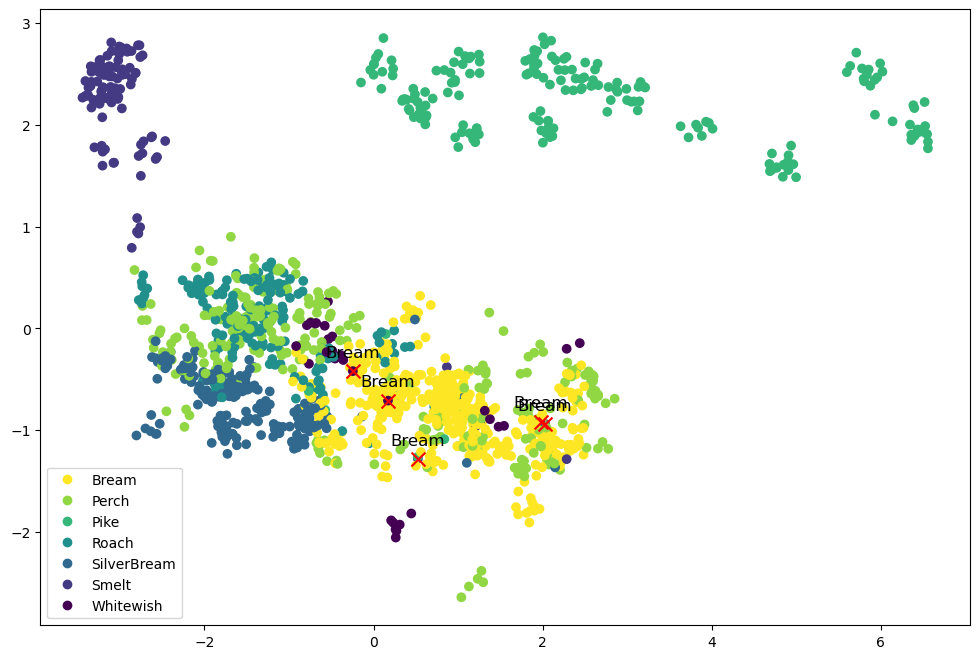

In [20]:

from sklearn.cluster import KMeans
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
import random

pca = PCA(n_components=6)


# pca = KernelPCA(n_components=6, kernel='rbf')

X_pca = pca.fit_transform(X_train)
X_pca = pd.DataFrame(X_pca, index=X_train.index)

clusters = KMeans(n_clusters=7, random_state=42).fit(X_pca)

# tsne = TSNE(n_components=2, random_state=42)
# X_pca = pca.fit_transform(X_train)
# X_pca = tsne.fit_transform(X_train)



class_names_map = {name: idx for idx, name in enumerate(sorted(set(y.unique())))}

class_names = [class_names_map[name] for name in y_train]

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca.iloc[:, 0], X_pca.iloc[:, 1], c=class_names, cmap='viridis_r')



plt.legend(handles=scatter.legend_elements()[0], labels=class_names_map.keys())




for index in random.sample(mispreds["index"].tolist(), k=5):
    plt.scatter(X_pca.loc[index, 0], X_pca.loc[index, 1], marker='x', s=100, c='red')
    predicted = df_cv[df_cv["index"] == index]["predictions_Logistic Regression"].values[0]
    plt.annotate(predicted, (X_pca.loc[index, 0], X_pca.loc[index, 1]), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=12, color='black')

